In [2]:
import random
import numpy as np
import torch

# Set seed for Python's random module
random.seed(42)

# Set seed for NumPy
np.random.seed(42)

# Set seed for PyTorch (CPU)
torch.manual_seed(42)

# If using GPU, also set the seed for CUDA
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# For deterministic behavior (may reduce performance)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms


# 1. Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# 2. Create a dataset from the folder
dataset = ImageFolder(root="Dataset", transform=transform)
print("Classes:", dataset.classes)  # Should print ['Cats', 'Dogs']

# Create a generator for DataLoader with a fixed seed
generator = torch.Generator()
generator.manual_seed(42)

# Split the dataset with the same fixed seed
total_size = len(dataset)
train_size = int(0.8 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size], generator=generator)

# Create DataLoaders using the generator for shuffling
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, generator=generator)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

dataiter = iter(train_loader)
images, labels = next(dataiter)
print("Images shape:", images.shape)  # Expected: (batch_size, 3, 128, 128)
print("Labels shape:", labels.shape)


Classes: ['Cats', 'Dogs']
Images shape: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32])


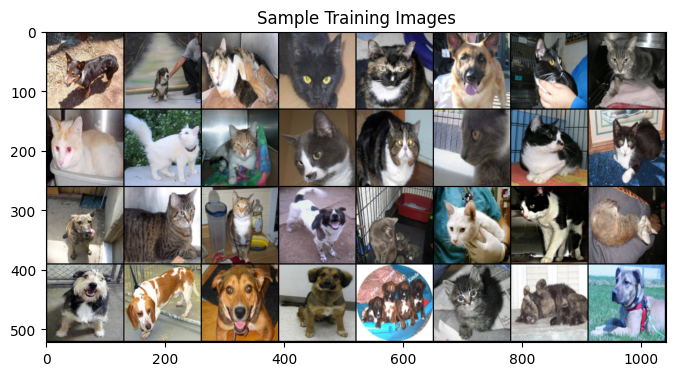

In [5]:
import matplotlib.pyplot as plt
import torchvision

# Display a grid of images
img_grid = torchvision.utils.make_grid(images)
plt.figure(figsize=(8,8))
plt.imshow(img_grid.permute(1,2,0).cpu().numpy())
plt.title("Sample Training Images")
plt.show()

In [6]:
import numpy as np

def print_label_distribution(loader, name="Loader"):
    all_labels = []
    for _, labels in loader:
        all_labels.extend(labels.cpu().numpy())
    unique, counts = np.unique(all_labels, return_counts=True)
    print(f"{name} label distribution:", dict(zip(unique, counts)))

print_label_distribution(train_loader, "Train")
print_label_distribution(val_loader, "Validation")

Train label distribution: {np.int64(0): np.int64(440), np.int64(1): np.int64(440)}
Validation label distribution: {np.int64(0): np.int64(110), np.int64(1): np.int64(110)}


A Convolutional Neural Network (CNN) is very effective for image classification 
because it automatically learns to extract important features (or "embeddings") from images—such as edges, textures, and shapes—through convolutional layers.

This is the standard way to define a neural network in PyTorch. inherits from nn.Module


Fully Connected Layers

Flattening the output:
After three rounds of pooling on an image of size 128x128:
128 → 64 (after conv1 + pool)
64 → 32 (after conv2 + pool)
32 → 16 (after conv3 + pool)
The feature maps from the last convolution have dimensions 64 channels × 16 × 16.
self.fc1 = nn.Linear(64 * 16 * 16, 128) creates a fully connected layer that takes this flattened vector as input and outputs 128 features.
Output Layer:
self.fc2 = nn.Linear(128, 2) maps the 128 features to 2 output classes (Cats and Dogs).

Convolutional Layers: Learn features from images.

Pooling: Reduces image dimensions and helps capture important features.

Flattening: Prepares data for the fully connected layers.

Fully Connected Layers: Make the final prediction (classifying into two classes).

In [7]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module): 
    def __init__(self):
        super(SimpleCNN, self).__init__() #This line calls the initializer of the parent class (nn.Module), which is necessary for PyTorch to manage your model correctly.
        # 1) Convolutional layers
        # Input channels: 3 (for RGB images).
        # Output channels: 16 (the number of filters that will learn features).
        # Kernel size: 3 (each filter is a 3x3 matrix).
        # Padding: 1 (keeps the spatial dimensions the same before pooling).
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        
        # 2) Fully connected layers
        # After 3 poolings on a 128x128 input, feature map is 16x16
        self.fc1   = nn.Linear(64 * 16 * 16, 128)
        self.fc2   = nn.Linear(128, 2)  # 2 classes: Cats and Dogs

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 128 -> 64
        x = self.pool(F.relu(self.conv2(x)))  # 64  -> 32
        x = self.pool(F.relu(self.conv3(x)))  # 32  -> 16
        x = x.view(-1, 64 * 16 * 16)          # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()
print(model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)


In [24]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.005
    maximize: False
    weight_decay: 0
)


In [25]:
num_epochs = 64
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
         # Get one small batch from train_loader
        data_iter = iter(train_loader)
        images, labels = next(data_iter)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print gradient norm for conv1 weights
        grad_norm = model.conv1.weight.grad.norm().item()
        # print("Gradient norm (conv1):", grad_norm)

        
        
        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.8f}")

    # Validation step
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total
    print(f"Validation Accuracy: {val_acc:.3f}%")


Epoch [1/64], Loss: 0.02488160
Validation Accuracy: 60.455%
Epoch [2/64], Loss: 0.02200966
Validation Accuracy: 58.636%
Epoch [3/64], Loss: 0.02077000
Validation Accuracy: 57.727%
Epoch [4/64], Loss: 0.00585431
Validation Accuracy: 56.364%
Epoch [5/64], Loss: 0.02916676
Validation Accuracy: 60.909%
Epoch [6/64], Loss: 0.04374541
Validation Accuracy: 61.818%
Epoch [7/64], Loss: 0.03239012
Validation Accuracy: 63.636%
Epoch [8/64], Loss: 0.05999231
Validation Accuracy: 64.091%
Epoch [9/64], Loss: 0.01357196
Validation Accuracy: 63.182%
Epoch [10/64], Loss: 0.00785890
Validation Accuracy: 62.273%
Epoch [11/64], Loss: 0.01038135
Validation Accuracy: 60.909%
Epoch [12/64], Loss: 0.00883269
Validation Accuracy: 62.273%
Epoch [13/64], Loss: 0.02615416
Validation Accuracy: 60.455%
Epoch [14/64], Loss: 0.02855083
Validation Accuracy: 61.364%
Epoch [15/64], Loss: 0.02627489
Validation Accuracy: 63.182%
Epoch [16/64], Loss: 0.02645517
Validation Accuracy: 58.182%
Epoch [17/64], Loss: 0.03361154
V

In [11]:
torch.save(model.state_dict(), "cats_vs_dogs_model.pth")

In [12]:
model = SimpleCNN()
model.load_state_dict(torch.load("cats_vs_dogs_model.pth"))
model.eval()

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=16384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)

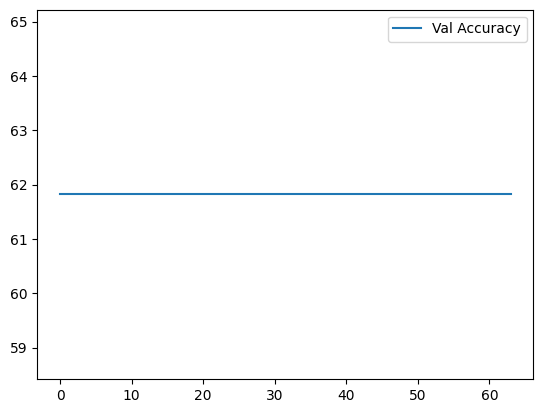

In [20]:
train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    val_accuracies.append(val_acc)

plt.plot(val_accuracies, label="Val Accuracy")
plt.legend()
plt.show()

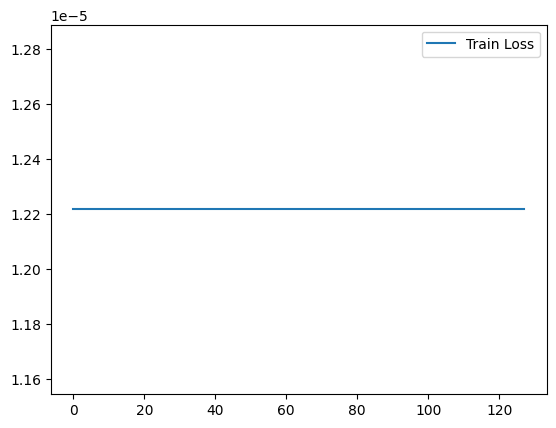

In [22]:
for epoch in range(num_epochs):
    train_losses.append(epoch_loss)
plt.plot(train_losses, label="Train Loss")
plt.legend()
plt.show()

In [23]:
# Get one small batch from the train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Print shapes to verify dimensions
print("Images shape:", images.shape)  # Should be [batch_size, 3, 128, 128]
print("Labels shape:", labels.shape)  # Should be [batch_size]

# Print unique labels in the batch to check encoding
print("Unique labels in this batch:", torch.unique(labels))

Images shape: torch.Size([32, 3, 128, 128])
Labels shape: torch.Size([32])
Unique labels in this batch: tensor([0, 1])
